c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      Unnamed: 0.12  Unnamed: 0.11  Unnamed: 0.10  Unnamed: 0.9  Unnamed: 0.8  \
4364           4364           4364           4364          4364          4364   
4365           4365           4365           4365          4365          4365   
4366           4366           4366           4366          4366          4366   
4367           4367           4367           4367          4367          4367   
4368           4368           4368           4368          4368          4368   

      Unnamed: 0.7  Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  \
4364          4364          4364          4364          4364          4364   
4365          4365          4365          4365          4365          4365   
4366          4366          4366          4366          4366          4366   
4367          4367          4367          4367          4367          4367   
4368          4368          4368          4368          4368          4368   

      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Epoch 1/10


Evaluating: 100%|██████████| 110/110 [00:30<00:00,  3.62it/s]


Train Loss: 0.8719 | Val Loss: 0.8673 | Val Acc: 0.6156 | Val F1: 0.4691

Epoch 2/10


Evaluating: 100%|██████████| 110/110 [00:32<00:00,  3.41it/s]


Train Loss: 0.8398 | Val Loss: 0.8612 | Val Acc: 0.6156 | Val F1: 0.4691

Epoch 3/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s]


Train Loss: 0.8086 | Val Loss: 0.8460 | Val Acc: 0.6304 | Val F1: 0.5681

Epoch 4/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s]


Train Loss: 0.7873 | Val Loss: 0.8433 | Val Acc: 0.6304 | Val F1: 0.5688

Epoch 5/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.28it/s]


Train Loss: 0.7471 | Val Loss: 0.8375 | Val Acc: 0.6442 | Val F1: 0.5965

Epoch 6/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s]


Train Loss: 0.7008 | Val Loss: 0.8561 | Val Acc: 0.6281 | Val F1: 0.5826

Epoch 7/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s]


Train Loss: 0.6216 | Val Loss: 0.8459 | Val Acc: 0.6350 | Val F1: 0.5702

Epoch 8/10


Evaluating: 100%|██████████| 110/110 [00:32<00:00,  3.43it/s]


Train Loss: 0.5615 | Val Loss: 0.8627 | Val Acc: 0.6236 | Val F1: 0.5844

Epoch 9/10


Evaluating: 100%|██████████| 110/110 [00:29<00:00,  3.68it/s]


Train Loss: 0.5182 | Val Loss: 0.8703 | Val Acc: 0.6156 | Val F1: 0.5809

Epoch 10/10


Evaluating: 100%|██████████| 110/110 [00:30<00:00,  3.55it/s]

Train Loss: 0.4939 | Val Loss: 0.8586 | Val Acc: 0.6224 | Val F1: 0.5682

Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.87      0.74       538
    positive       0.49      0.27      0.35       267
     neutral       0.50      0.01      0.03        69

    accuracy                           0.62       874
   macro avg       0.55      0.39      0.37       874
weighted avg       0.59      0.62      0.57       874



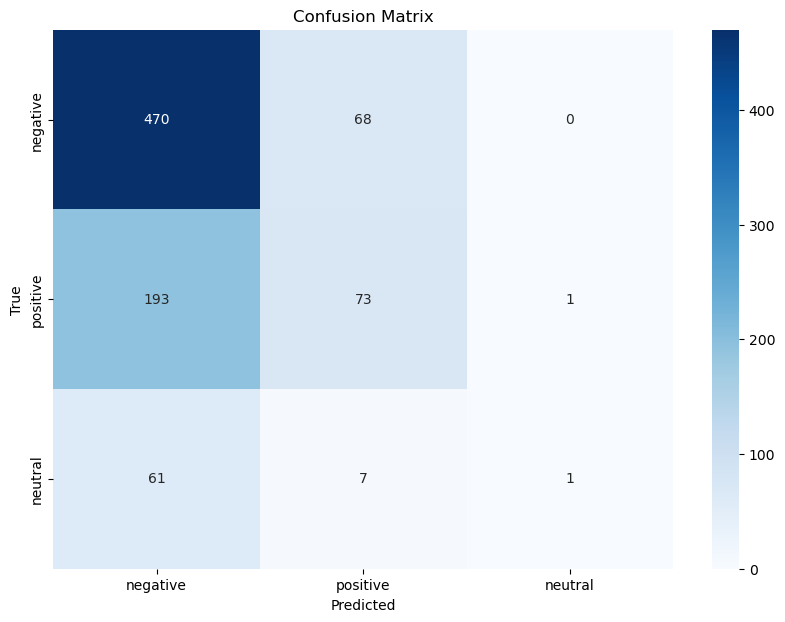

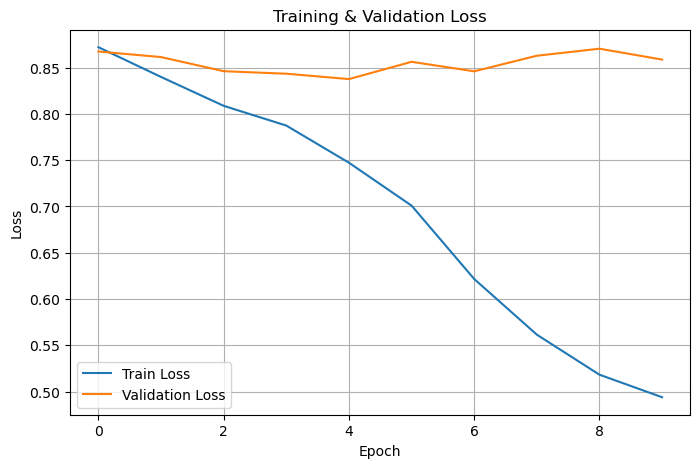

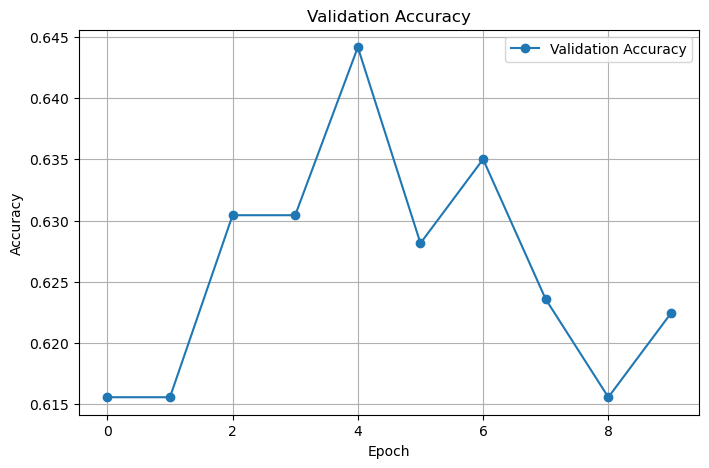

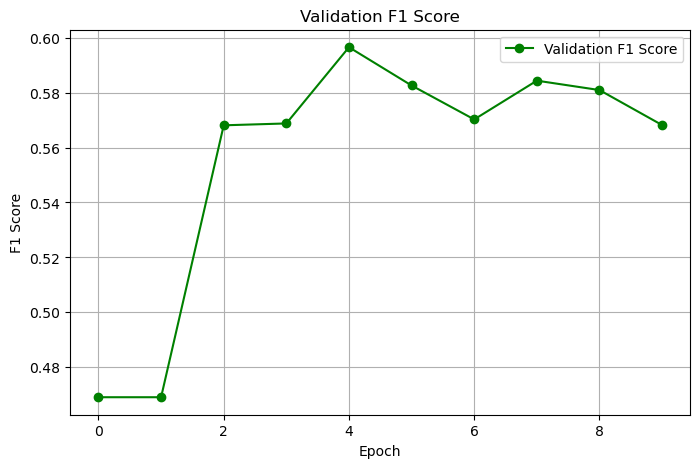

In [1]:
# ====================== Imports ======================
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

folder = "Dataset/Memes"

for filename in os.listdir(folder):
    new_filename = filename.replace(' ', '_')
    os.rename(os.path.join(folder, filename), os.path.join(folder, new_filename))

def clean_filename(name):
    name = re.sub(r'\s+', ' ', str(name).strip())
    name = name.replace(' ', '_')
    return name

# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "Dataset/Memes"
CSV_PATH = "Dataset/multi-sent.xlsx"
NUM_LABELS = 3
LABEL_MAP = {'negative': 0, 'positive': 1, 'neutral': 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
BATCH_SIZE = 8
EPOCHS = 10

df = pd.read_excel(CSV_PATH)
df['image_name'] = df['image_name'].apply(clean_filename)

print(df.tail())
df.to_excel(CSV_PATH)

# ====================== Dataset ======================
class MemeDataset(Dataset):
    def __init__(self, records, processor, img_dir):
        self.data = records
        self.processor = processor
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]

        image_name = clean_filename(row['image_name'])
        image_path = os.path.join(self.img_dir, image_name)

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        text = str(row['Captions'])
        label = LABEL_MAP[row['Label_Sentiment']]

        # Use processor to prepare inputs for both image and text
        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)

        # Remove batch dim because DataLoader will batch
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(label)

        return inputs

# ====================== Model ======================
class CLIPClassificationHead(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.dropout = nn.Dropout(0.3)

        # CLIP image and text embeddings are 512 dim
        # You can choose to use only image embeddings or concat image + text embeddings for classification
        # Here, let's use concatenated image + text embeddings (512 + 512 = 1024)
        self.classifier = nn.Linear(1024, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )

        # Extract pooled image and text embeddings
        image_embeds = outputs.image_embeds  # shape: (batch_size, 512)
        text_embeds = outputs.text_embeds    # shape: (batch_size, 512)

        # Concatenate image and text embeddings
        combined_embeds = torch.cat([image_embeds, text_embeds], dim=1)  # shape: (batch_size, 1024)

        combined_embeds = self.dropout(combined_embeds)
        logits = self.classifier(combined_embeds)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

# ====================== Train & Eval Functions ======================
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels

# ========== Custom Collate Function ==========
def custom_collate(batch):
    keys = batch[0].keys()
    collated = {}
    for key in keys:
        if key == "labels":
            collated[key] = torch.tensor([item[key] for item in batch])
        else:
            collated[key] = torch.nn.utils.rnn.pad_sequence([item[key] for item in batch],
                                                            batch_first=True, padding_value=0)
    return collated

# ====================== Run ======================
df = pd.read_excel(CSV_PATH)
records = df.to_dict(orient="records")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
dataset = MemeDataset(records, processor, IMG_DIR)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

model = CLIPClassificationHead(num_labels=NUM_LABELS).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

train_losses, val_losses = [], []
final_preds, final_labels = [], []
train_accuracies, val_accuracies, val_f1s = [], [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

    train_accuracies.append(None)
    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    scheduler.step()
    final_preds = preds
    final_labels = labels

# ========== Evaluation ==========
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=LABEL_MAP.keys()))

# ========== Visualization ==========
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
conf_mat = confusion_matrix(final_labels, final_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_plot.png")
plt.show()
